# 미니 프로젝트 : 폐렴 진단기 성능 개선

의료 인공지능은 다양한 분야에서 사용되고 있다. 질병의 정확한 분류 또는 환자의 중등도를 확인하는 용도 등 다양한 용도로 사용된다.

이 중에서 현재 가장 핫한 분야는 __질병을 탐지해내는 인공지능___ 이다.

[캐글의 Chest X-Ray Images](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) 데이터셋을 사용하여 

숙련된 의사들과 비슷한 90% 이상의 정확도를 갖진 X-RAY 사진 판독 폐렴 진단기를 만들어보자.

----
## 1. Set-up
### 필요한 모듈 불러오기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

### 필요한 변수 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'


BATCH_SIZE = 32
EPOCHS = 25

----
## 2. 데이터 준비

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(f'train 개수: {len(train_filenames)}')
print(f'validation 개수 : {len(val_filenames)}')
print(f'test 개수 : {len(test_filenames)}')

train 개수: 5216
validation 개수 : 16
test 개수 : 624


### train, val 데이터 조정

val 개수가 너무 적기 때문에 train 과 val 에 있는 데이터를 모은 다음에 8:2 로 분할한다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담는다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(f'train 개수: {len(train_filenames)}')
print(f'validation 개수 : {len(val_filenames)}')
print(f'test 개수 : {len(test_filenames)}')

train 개수: 4185
validation 개수 : 1047
test 개수 : 624


In [5]:
# 파일 경로 확인
for i in range(10):    
    print(f'image path : {filenames[i]}')

image path : /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person75_bacteria_368.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person400_bacteria_1807.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person433_virus_882.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person641_virus_1222.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0369-0001.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0429-0001.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0294-0001.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0553-0001.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person731_bacteria_2633.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1320_bacteria_3351.jpeg


파일 경로을 확인해보면 정상 이미지는 `NORMAL` 에 속해있고, 폐렴 이미지는 `PNEUMONIA` 에 속해있는 것을 알 수 있다.

In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1097
Pneumonia images count in training set: 3088


정상보다 폐렴 이미지 수가 3배 더 많이 있다.

CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘한다.

데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정이다.

###  tf.data 인스턴스 생성

배치처리 작업을 보다 효율적으로 할 수 있도록 `tf.data` 인스턴스를 만들자.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지 데이터에는 라벨 데이터가 없다.  

파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들자.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄인다.  

이를 위해 `decode_img` 와 `process_path` 함수를 정의한다.

In [10]:
# 이미지를 알맞은 형식으로 바꾼다
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어온다
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만든다.  

`num_parallel_calls` 파라미터에서 `set-up`에서 초기화 한 `AUTOTUNE` 을 이용하면 더욱 빠르게 데이터를 처리해준다.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# resizae, labeling 된 이미지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


 train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어보자.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# test 데이터 개수 확인
print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다. 

밑에 있는 `prepare_for_training()` 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시킨다.
- `shuffle()` :고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
- `repeat()` : epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 `repeat()`를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용
- `batch()` : BATCH_SIZE에서 정한 만큼의 배치로 주어짐
- `prefetch()` : 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


처음에 `BATCH_SIZE` 를 `32` 으로 지정했으므로  

image_batch는 `(32, 180, 180, 3)` 형상의 텐서이며, 180x180x3 형상의 32개 이미지 묶음으로 되어 있습니다(마지막 차원은 색상 채널 RGB를 나타냄). 

label_batch는 형상 (32,)의 텐서이며 32개 이미지에 해당하는 레이블이다.

### Data Augmentation 

전처리 레이어를 사용하여 데이터 증강을 한다.
각 레이어는 다음과 같다.
- `RandomFlip` : 가로, 세로로 무작위로 뒤집음 (`horizontal` 은 좌우반전)
- `RandomRotation` : 무작위로 회전 (`0.1` 은 `-10% * 2pi, 10% * 2pi` 중 임의의 양 만큼 회전)
- `RandomZoom` : 무작위로 확대/축소 (`(-0.2,0.2)` 은 `-20%, +20%` 범위 내에서 확대/축소)
- `RandomTranslation` : 수직, 수평으로 이동 ( 수직/수평 이동 `-10%, +10%`, `fill_mode` 는 입력 경계 외부의 점은 모두 0(검정) 으로 채움

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),  # 좌우 반전
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),       # 회전
  tf.keras.layers.experimental.preprocessing.RandomZoom(-0.2,0.2),     # 확대/축소
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1,
                                                               fill_mode='constant')  # 이미지 상하 이동
])

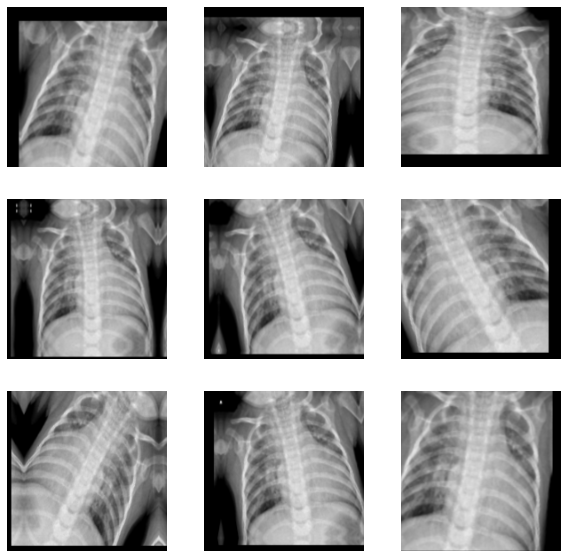

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0])
    plt.axis("off")

----
## 3. 데이터 시각화

train에 있는 batch 중 첫 번째 배치를 추출하여 배치를 image와 label 데이터 셋으로 나눈다. 그 후 show_batch() 함수를 이용해서 결과 사진을 보자.

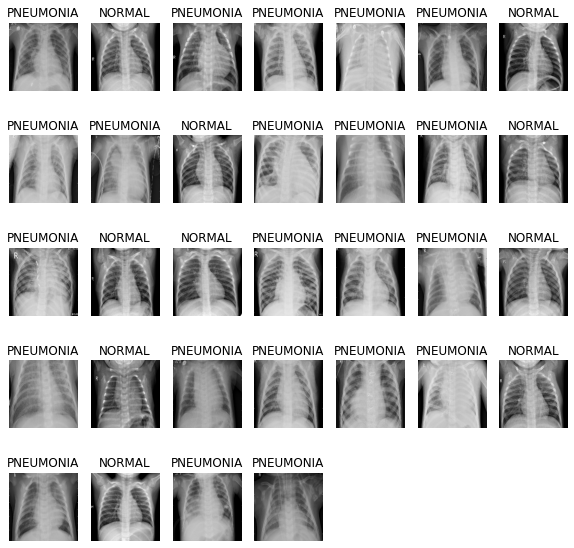

In [18]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여준다
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

----
## 4. CNN 모델 생성

Convolution block 의 구성은 아래와 같다.

- Convolution 두 번 진행
- Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결
- Max pooling

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

Dense Block은 아래와 같이 만든다.

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### 모델 생성

위에서 생성한 Data Augmentation 레이어와 Convolution block 과 Dense Block 를 사용해 모델을 생성한다.

In [21]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        data_augmentation,  # 데이터 증강 레이어
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

----
## 5. 데이터 imbalacnce 처리
Weight balancing 을 통해 데이터 불균형을 해결한다.  


weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정한다.

- `weight_for_0` : Normal 이미지에 사용할 weight
- `weight_for_1` : Pneumonia 이미지에 사용할 weight

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.91
Weight for PNEUMONIA: 0.68


----
## 6. 모델 훈련

- 이미지 훈련은 GPU를 사용할 것이기 때문에 GPU를 선택
- 모델은 위에서 만들었던 모델 함수인 `build_model()` 선언
- 이미지의 라벨이 두 개밖에 없기 때문에 `binary_cross entropy` loss를 사용
- optimizer로 `adam`을 사용
- 성과에 대해서 측정하기 위한 metrics으로 `accuracy`, `precision`, `recall`을 사용

In [23]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_2 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_3 (Sequential)    (None, 11, 11, 128)      

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 54s 276ms/step - loss: 0.6413 - accuracy: 0.6652 - precision: 0.8895 - recall: 0.6232 - val_loss: 0.5809 - val_accuracy: 0.7627 - val_precision: 0.7627 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 34s 263ms/step - loss: 0.3649 - accuracy: 0.8469 - precision: 0.9621 - recall: 0.8231 - val_loss: 0.6036 - val_accuracy: 0.7607 - val_precision: 0.7607 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 34s 263ms/step - loss: 0.3368 - accuracy: 0.8651 - precision: 0.9560 - recall: 0.8571 - val_loss: 0.8854 - val_accuracy: 0.7617 - val_precision: 0.7617 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 34s 261ms/step - loss: 0.2808 - accuracy: 0.8877 - precision: 0.9680 - recall: 0.8766 - val_loss: 1.5097 - val_accuracy: 0.7559 - val_precision: 0.7559 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 34s 263ms/step - loss: 0.2864 - accura

----
## 7. 결과 확인
그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보자.

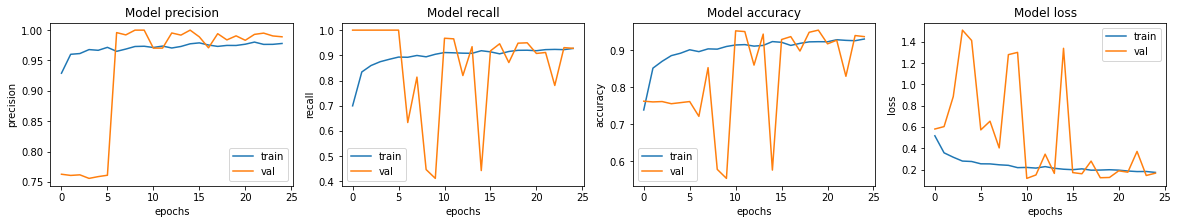

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

테스트 데이터로 모델을 평가한다.

In [27]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 9s 425ms/step - loss: 0.2635 - accuracy: 0.9087 - precision: 0.9111 - recall: 0.9462
Loss: 0.26348572969436646,
Accuracy: 0.9086538553237915,
Precision: 0.9111111164093018,
Recall: 0.9461538195610046


### 결과적으로 약 91% 의 Accuracy,  약 95% 의 Recall  값이 나왔다.

----
# 프로젝트 정리


#### 데이터 준비
- val 개수가 너무 적음  
  --->  train 과 val 에 있는 데이터를 모은 다음에 8:2 로 분할  


- 정상보다 폐렴 이미지 수가 3배 (불균형 데이터)  
  ---> Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여
  

- 의료 영상 이미지 특성상 데이터 부족  
  ---> Data Augmentation (좌우 반전, 회전, 확대/축소, 상 하 이동)



- Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding 해결  


- Dropout 을 사용하여 과적합(overfitting) 방지

|설정|BATCH_SIZE|EPOCHS|Data Augmentation|Batch Normalization|Dropout|Accuracy|
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
|Baseline|16|25|X|O|O|0.73|
|Test1|16|25|O|O|O|0.88|
|__Test2 (Final)__|__32__|__25__|__O__|__O__|__O__|__0.90__|
|Test3|32|20|O|O|O|0.71|
|Test4|32|30|O|O|O|0.68|
|Test5|32|25|O|X|O|0.89|
|Test6|32|25|O|O|X|0.90|

위의 표와 같이 다양한 변수들을 바꿔서 실험을 해보았고 결과적으로  
- Test2 (BATCH_SIZE = 32, EPOCHS = 25, Data Augmentation = O, Batch Normalization = O, Dropout = O)
- Test6 (BATCH_SIZE = 32, EPOCHS = 25, Data Augmentation = O, Batch Normalization = O, Dropout = X)  

의 정확도(Accuracy) 가 약 90% 로 가장 높게 나왔다.  

이 둘의 Recall 값을 비교해보면,
- Test2 : 0.95
- Test6 : 0.92  
로 Test2 의 Recall 값이 약 95% 로 더 높아서 Test2를 Final 모델로 생성했다.

위 코드의 모든 과정은 Test2 에 해당하는 코드이다.

## 결과적으로 약 91% 의 Accuracy, 약 95% 의 Recall 값이 나왔다.

숙련된 의사분들은 90% 이상에 도달한다고 하니 꽤 준수한 모델이 생성되었음을 알 수 있다.